In [68]:
import graph_tool.all as gt
import matplotlib.pyplot as plt
import numpy as np
# dependencia para o processo de inferência
from scipy import integrate, optimize

import warnings

In [69]:
def sir_model2(y, x, beta):
    '''
        `y` contém o número de suscetível, infectados e recuperados
    '''
    N = y[0] + y[1] + y[2]
    S = -beta * y[0] * y[1] / N
    R = 0.1428 * y[1] # note o gamma travado
    I = -(S + R)
    return S, I, R

def make_fit2(state):
    '''
    Aqui tem uma pequena gambiarra. Conforme o experimento essa função cria retorna função que utiliza o valor de `x`
    (id da série histórica) e o beta integrando sobre a edo estipulada na função `sir_model2`. 
    
    Em resumo, a partir de um estado definido por uma tupla (suscetível, infectado, recuperado) e um índice histórico
    (sequência númerica) ele integra e retorna o valor de infectados.
    '''
    def fit_odeint(x, beta):
        S0, I0, R0 = state
        return integrate.odeint(sir_model2, 
                                (S0, I0, R0),
                                x, 
                                args=(beta,),
                                mxstep=6000)[:,1] # retorna só a segunda posíção, que é o número de infectados
    return fit_odeint

def lambda_estimate(state, infected): 
    '''
        `state` receberá o número inicial de suscetíveis, infectados e recuperados.
        `xaxis` retorna os valores de que, no caso, são a identificação da série histórica (cada dia por ex.)
        `infected` recebe a série histórica de infectados `numpy.ndarray`.
        
        Note que ele vai tentar ajustar a variável beta da função `make_fit2` utilizando um índice históricoo passado
        no parâmetro `x`.
        
        Note que ele vai ajustar a partir da função retornada pela função `make_fit2` através de inferência
        com os mínimos quadrados o valor de beta de forma a função retorne valores próximos àqueles passados na
        variável `infected` que contabiliza de indivíduos que se tornaram infectados em cada dia.
    '''
    warnings.filterwarnings('ignore')
    xaxis = np.arange(len(infected))
    popt, pcov = optimize.curve_fit(make_fit2(state),
                                    xaxis,
                                    infected,
                                    maxfev=6000)
    return popt, pcov

Exemplo, utilizando a EDO como referência, imagine um cenário onde existe 2431 indivíduos onde um deles se infectou. O retorno da EDO seria equivalente ao array abaixo, aplicando um beta de $0.2814$.

***Nota***: o gamma está travado na função do SIR com $0.1428$.

In [70]:
# retorna a função com o estado que criei
fitted = make_fit2((2429, 1, 0))

# monta a série histórica com 60 unidades (índices) históricos
fitted(np.arange(60), 0.2814)

array([  1.        ,   1.14851192,   1.31903024,   1.51480004,
         1.73953996,   1.99750969,   2.29358626,   2.63335136,
         3.02318887,   3.47039563,   3.9833056 ,   4.57142891,
         5.24560683,   6.01818378,   6.90319669,   7.91658227,
         9.07640154,  10.40308036,  11.91966321,  13.65207598,
        15.62939114,  17.88408541,  20.45227699,  23.37392408,
        26.692961  ,  30.45734165,  34.71895188,  39.53334445,
        44.95924095,  51.05773693,  57.89114015,  65.52136854,
        74.00783754,  83.40477834,  93.75795271, 105.10076994,
       117.44986769, 130.80030419, 145.12058199, 160.34785755,
       176.38376422, 193.0913734 , 210.29384914, 227.77532226,
       245.28439862, 262.54050874, 279.24302381, 295.08273171,
       309.75493939, 322.9732041 , 334.48254916, 344.07102709,
       351.57865809, 356.90306849, 360.00153004, 360.88948824,
       359.63600675, 356.35679892, 351.20564619, 344.36501886])

Note, quando maior o número de infectados inicial, mais rápido se antige o pico ...

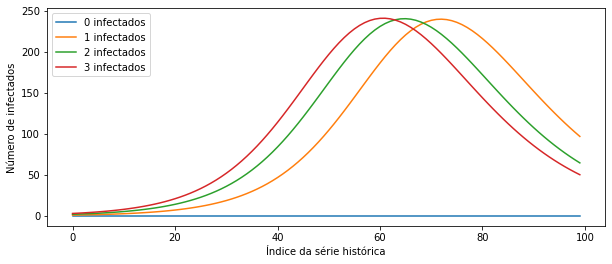

In [82]:
fig = plt.figure(figsize=(10,4))
xaxis = np.arange(100)
for x in range(4):
    fitted = make_fit2((2429-x, x, 0))
    plt.plot(fitted(xaxis, 0.2418), label=f'{x} infectados')
    plt.legend()
plt.xlabel('Índice da série histórica');
plt.ylabel('Número de infectados');

Para testar, imagine uma simulação com 60 iterações do SIR em uma rede complexa. Depois, tentamos ajustar os resultados obtidos da simulação (número de infectados) ao modelo determinístico (EDO).

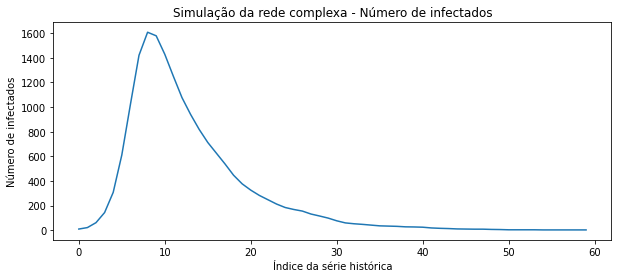

In [90]:
path = 'out.moreno_health'
graph = gt.load_graph_from_csv(path, csv_options={"delimiter": " "},directed=False)

# infecto os nós de 0 a 3
condition = graph.new_vertex_property("int")
condition.a.fill(0)
condition.a[0:10] = 1
iterator = 60

state = gt.SIRState(graph, beta=0.2857, gamma=0.1428, s=condition)
output = np.zeros(iterator, dtype='int')
# conta o número de infectados (valor 1) e jogo na 1 posição do vetor com a saída dos infectados
s0 = int((condition.a==0).sum())
output[0] = int((condition.a==1).sum())
num_vertices = int(graph.num_vertices())

# itero 60 vezes o espalhamento na rede e jogo o número de infectados em output
for c in range(1, iterator):
    state.iterate_sync()
    s = state.get_state().fa
    output[c] = int((s==1).sum())

fig = plt.figure(figsize=(10,4))
plt.plot(output);
plt.title('Simulação da rede complexa - Número de infectados')
plt.xlabel('Índice da série histórica');
plt.ylabel('Número de infectados');

Enfim, ajustar o parâmetro $\beta$ com o $\gamma$ fixo aos valores de infectados obtidos na simulação da rede complexa. O beta inferido é exibido abaixo.

In [94]:
popt, pcov = lambda_estimate((s0, output[0], num_vertices-s0-output[0]), output)
popt

array([1.06529636])

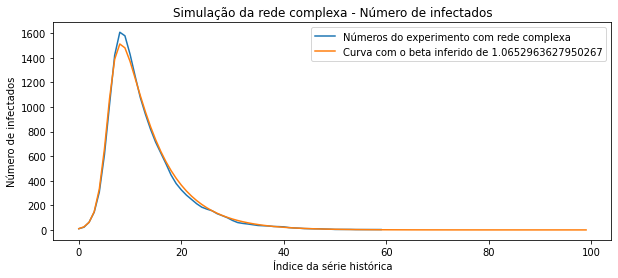

In [101]:
fitted = make_fit2((s0, output[0], num_vertices-s0-output[0]))

fig = plt.figure(figsize=(10,4))
plt.plot(output, label='Números do experimento com rede complexa');
plt.plot(fitted(xaxis, popt), label=f'Curva com o beta inferido de {popt[0]}')
plt.title('Simulação da rede complexa - Número de infectados')
plt.xlabel('Índice da série histórica');
plt.ylabel('Número de infectados');
plt.legend();